In [19]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/10800619/ipykernel_2575197/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/10800619/ipykernel_2575197/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/10800619/ipykernel_2575197/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_p

In [20]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [21]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [22]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [23]:
import glob

In [24]:
import regions
from astropy.io import fits

In [152]:
cd /orange/adamginsburg/jwst/brick/F405N/pipeline/

/blue/adamginsburg/adamginsburg/jwst/brick/mastDownload/JWST/F405N/pipeline


In [25]:
reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/overlapref.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/overlap2.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/pos.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/detectoroverlap_problemzone2.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/middle.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/topleft.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/topright.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/bottomleft.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/bottomright.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/nrcb_mini.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/check.reg')

#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/nrcb_try.reg')

In [26]:
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*_cal.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*_destreak.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*long_i2d.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*merged*i2d.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*long_outlier_i2d.fits")
#files = glob.glob('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*realigned_to_outlier_i2d.fits')
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*destreak_align.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*long_align.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*realigned.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*realigned_to_vvv.fits")
files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*align*tweakregstep.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*outlierdetectionstep.fits")
#files = glob.glob('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_20230725t121309_image3_00005_nrc*_asn_*_outlier_i2d.fits')
#files = glob.glob('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/step_OutlierDetectionStep_jw02221-o002_20230725t121309_image3_00005_nrc*_asn_*_o002_blot.fits')
#files = glob.glob('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_20230725t121309_image3_00005_nrc*_asn_*_o002_outlierdetectionstep.fits')
#files = glob.glob('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_20230725t121309_image3_00005_nrc*_asn_*_skymatchstep.fits')
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/step_SkyMatchStep*skymatchstep.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*resamplestep.fits")
#files = glob.glob('/blue/adamginsburg/adamginsburg/jwst/cloudc/reduction/brick-jwst-2221/reduction/*_destreak_tweakregstep.fits')
#files = glob.glob('/blue/adamginsburg/adamginsburg/jwst/cloudc/reduction/brick-jwst-2221/reduction/*jhat.fits')
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_t001_nircam_clear-f405n-*_i2d.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*median*")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*refcat*.fits")

len(files), files[:3]

(33,
 ['/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00003_nrcblong_align_tweakregstep.fits',
  '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00004_nrcblong_align_tweakregstep.fits',
  '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00003_nrcblong_align_tweakregstep.fits'])

In [27]:
import warnings

In [28]:
fits.open(files[0])


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x148974b50f70>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148903644fa0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199100>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199340>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199580>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199820>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199a60>, <astropy.io.fits.hdu.image.ImageHDU object at 0x148906199ca0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1489061a7040>]

In [29]:
reg[0].to_pixel(wcs.WCS(fits.getheader(files[0], ext=1))).to_mask()

Set DATE-AVG to '2023-04-25T04:17:03.110' from MJD-AVG.
Set DATE-END to '2023-04-25T04:17:29.952' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -11.487662 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386104450.505 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    masks = [reg[0].to_pixel(wcs.WCS(fits.getheader(fn, ext=1))).to_mask() for fn in files]
    shapes = [fits.getdata(fn, ext=1).shape for fn in files]
    cutouts = [mask.cutout(fits.getdata(fn, ext=1)) for mask,fn in zip(masks, files)]

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [31]:
len(cutouts)

33

In [32]:
import numpy as np

In [33]:
len([c for c in cutouts if np.any(c)])

10

In [34]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/jw02221-o002_t001_nircam_clear-F405N-merged_vvvcat.ecsv')
crds = tbl['skycoord']
crds_in = crds[reg[0].contains(crds, wcs=wcs.WCS(fits.getheader(files[0], ext=1)))]

Set DATE-AVG to '2023-04-25T04:17:03.110' from MJD-AVG.
Set DATE-END to '2023-04-25T04:17:29.952' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -11.487662 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386104450.505 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


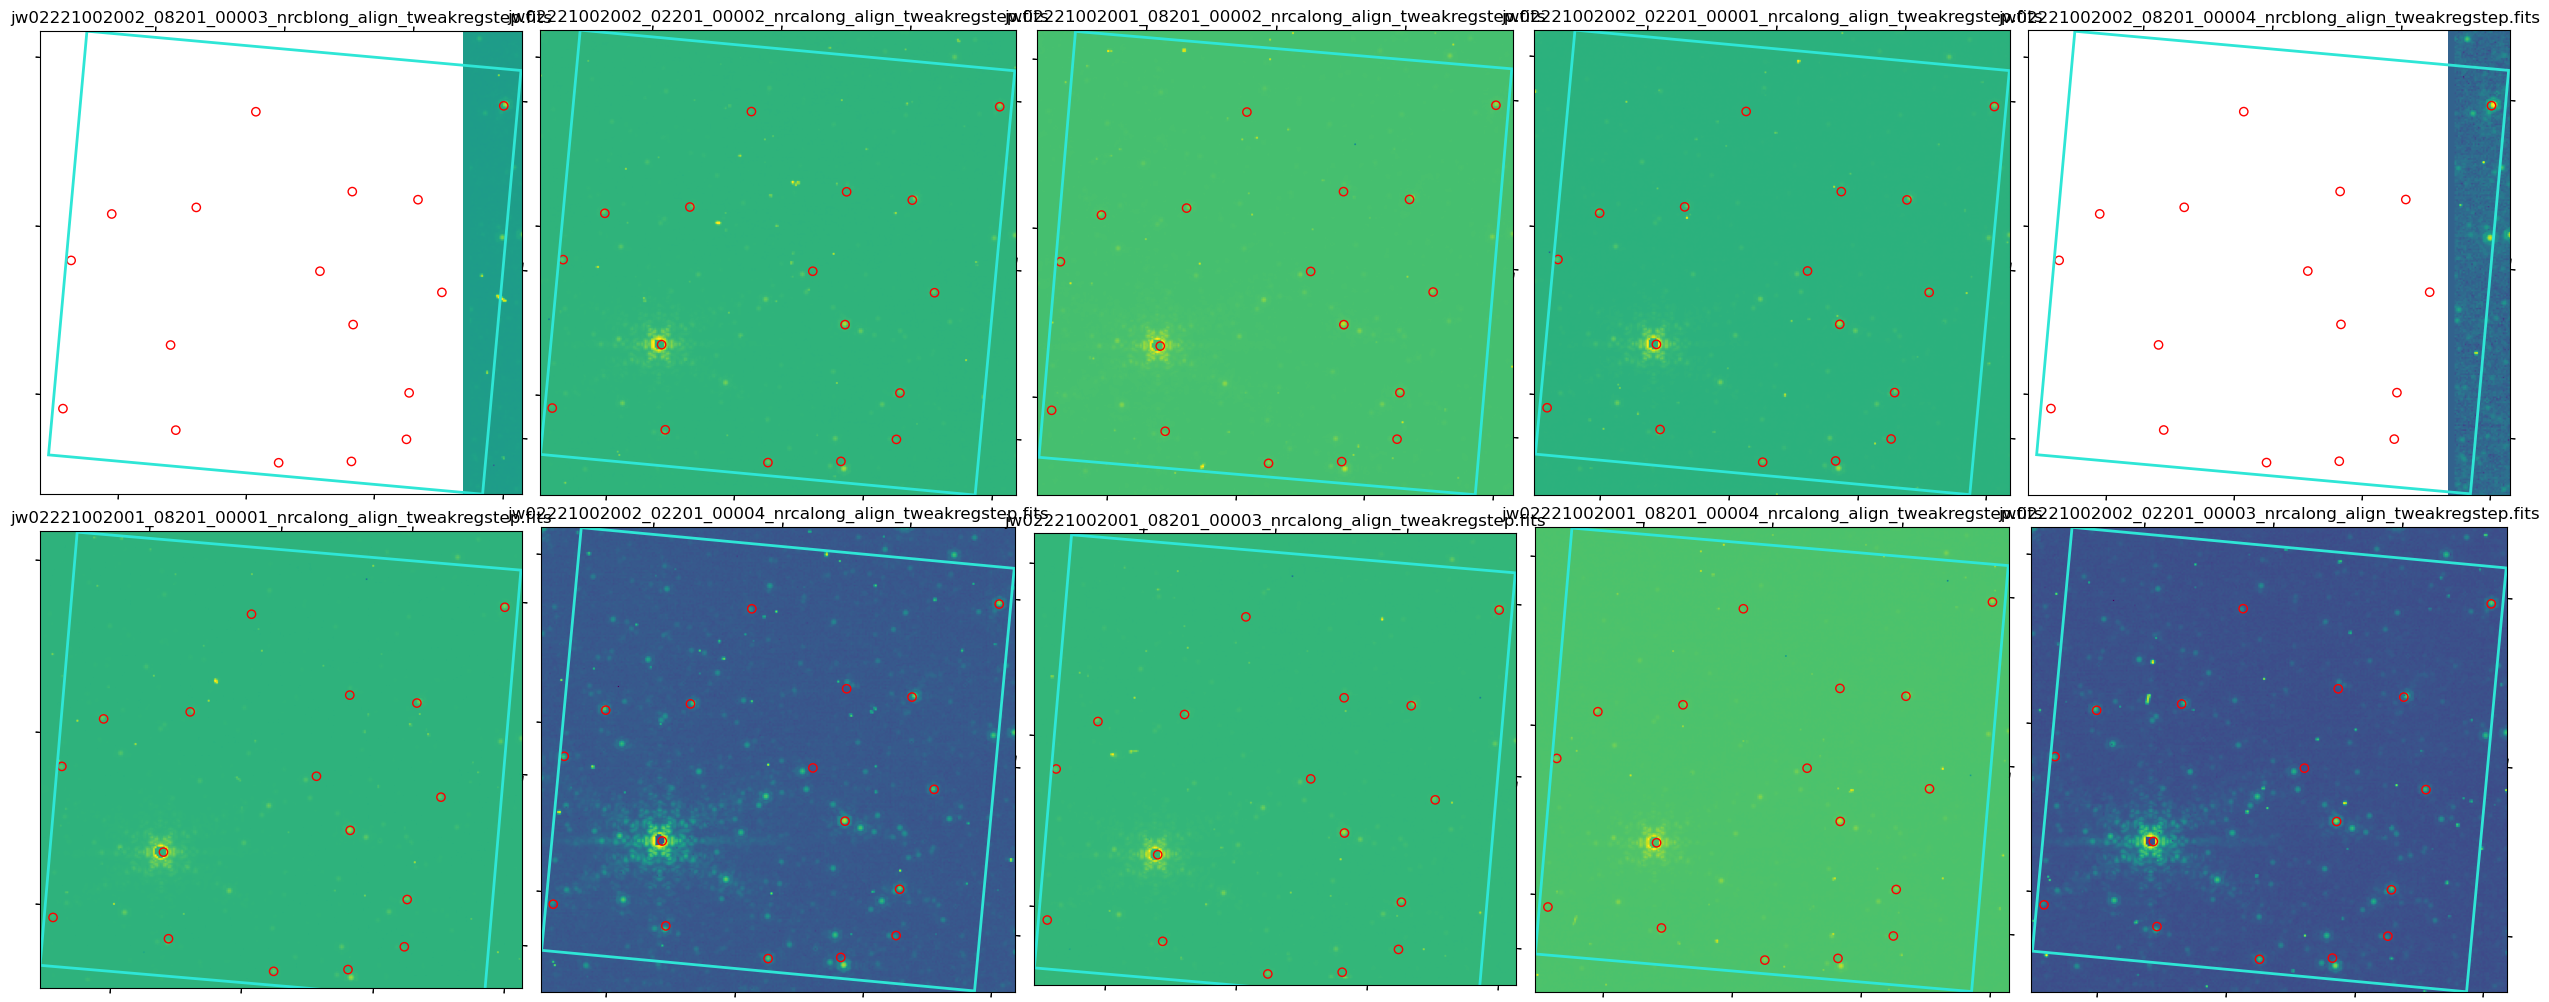

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co)]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(5,5,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        titl = fn.split('/')[-1]
        ax.set_title(titl)
        ax.imshow(np.nan_to_num(co), origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.99))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

In [105]:
#tbl = Table.read('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcalong_destreak_realigned_to_vvv_cat.ecsv')
#crds = tbl['skycoord']

In [20]:
print(

SyntaxError: unexpected EOF while parsing (149104261.py, line 1)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co) and (co > 0).sum() > 20000]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(4,4,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        ax.set_title(fn)
        ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

In [ ]:
ww = wcs.WCS(fits.getheader(fn, ext=1))
ww

In [ ]:
starreg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/overlap_refstar.reg')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    ii = 1
    for fn in files:
        hdr = fits.getheader(fn, ext=1)
        ww = wcs.WCS(hdr)
        if ww.footprint_contains(starreg[0].center):
            preg = starreg[0].to_pixel(ww)
            mask = preg.to_mask()
            data = fits.getdata(fn, ext=1)
            slcs,_ = mask.get_overlap_slices(data.shape)
            co = data[slcs]
            if not np.any(co) or slcs is None:
                continue
            #print(slcs)
            ax = pl.subplot(5,5,ii, projection=ww[slcs])
            ii+=1
            ax.set_title(fn)
            ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
            crds_in2 = crds[starreg[0].contains(crds, wcs=ww)]
            ax.scatter(crds_in2.ra, crds_in2.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
            ax.set_xticks([])
            ax.set_yticks([])
            print(f'{os.getcwd()}/{fn}')
    pl.tight_layout()

await app.openFile("/jwst/brick/mastDownload/JWST/F212N/jw02221-o001_t001_nircam_clear-f212n_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00019_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00004_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00014_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00001_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00020_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00007_nrca4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00002_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00018_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00017_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00003_nrca3_i2d.fits")

In [ ]:
import asdf

In [ ]:
def gwcs_in(gwcs, coord, shape):
    ymax, xmax = shape
    x, y = gwcs.world_to_pixel(coord)
    return (x < xmax) & (x > 0) & (y < ymax) & (y > 0)

In [ ]:
starreg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/overlap_refstar.reg')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    ii = 1
    for fn in files:
        hdr = fits.getheader(fn, ext=1)
        ww = wcs.WCS(hdr)
        gwcs = asdf.open(fn).tree['meta']['wcs']
        data = fits.getdata(fn, ext=1)
        if gwcs_in(gwcs, starreg[0].center, data.shape):
            preg = starreg[0].to_pixel(gwcs)
            mask = preg.to_mask()
            slcs,_ = mask.get_overlap_slices(data.shape)
            co = data[slcs]
            if not np.any(co) or slcs is None:
                continue
            #print(slcs)
            ax = pl.subplot(5,5,ii, projection=gwcs[slcs])
            ii+=1
            ax.set_title(fn)
            ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
            crds_in2 = crds[starreg[0].contains(crds, wcs=gwcs)]
            ax.scatter(crds_in2.ra, crds_in2.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
            ax.set_xticks([])
            ax.set_yticks([])
            print(f'{os.getcwd()}/{fn}')
    pl.tight_layout()

In [ ]:
fits.open(fn)[('SCI', 1)]

In [ ]:
from astropy import coordinates

In [ ]:
regions.PolygonSkyRegion(coordinates.SkyCoord(gwcs.footprint(), unit=(u.deg, u.deg), frame='fk5'))

In [ ]:
gwcs.world_to_pixel(starreg[0].center)

In [ ]:
#gwcs.backward_transfo(starreg[0].center.ra, starreg[0].center.dec)

In [ ]:
starreg[0].center

In [ ]:
starreg[0].center.to_pixel(gwcs)

In [ ]:
gwcs.array_shape

In [ ]:
ww.array_shape